Using device: cuda:0


2024-10-03 16:02.12 [warning  ] could not import PCL           [latentfusion.pointcloud]
/tmp/ipykernel_37606/3888276864.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

recon_error 0.03720211237668991


/home/icore-az/latentfusion-az-fork/latentfusion/three/orientation.py:86: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  right = three.normalize(torch.cross(down, forward))
2024-10-03 16:02.17 [info     ] loading pose estimator from config [latentfusion.pose.estimation] init_hemisphere=False init_upright=False learning_rate=0.3 loss_weights={'depth': 0.0, 'ov_depth': 0.0, 'iou': 0.0, 'mask': 0.0, 'latent': 1.0} num_elites=48 num_gmm_components=6 num_iters=30 num_samples=96 ranking_size=16 return_camera_history=False sample_flipped=True type=cross_entropy verbose=False


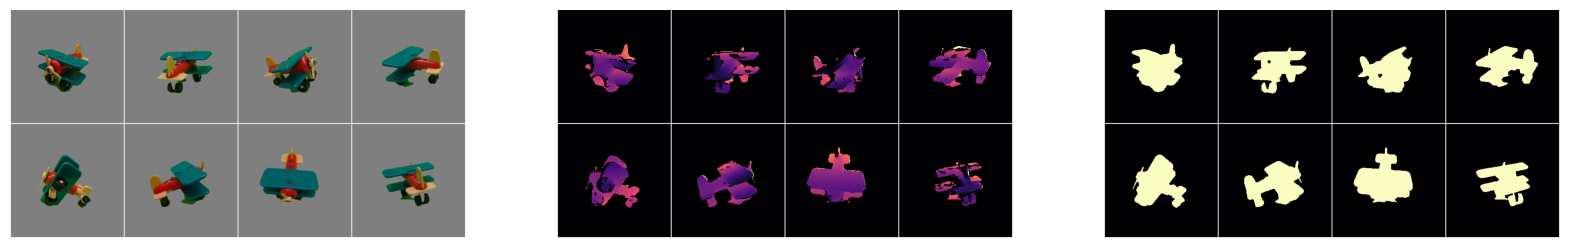

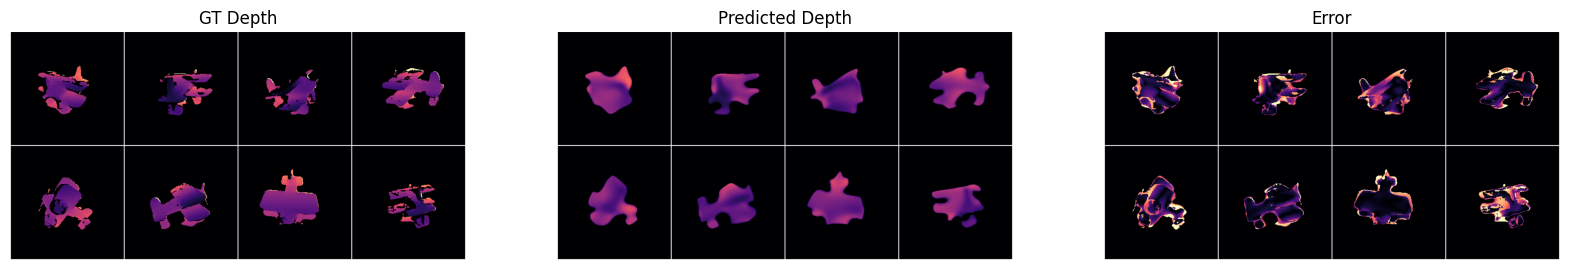

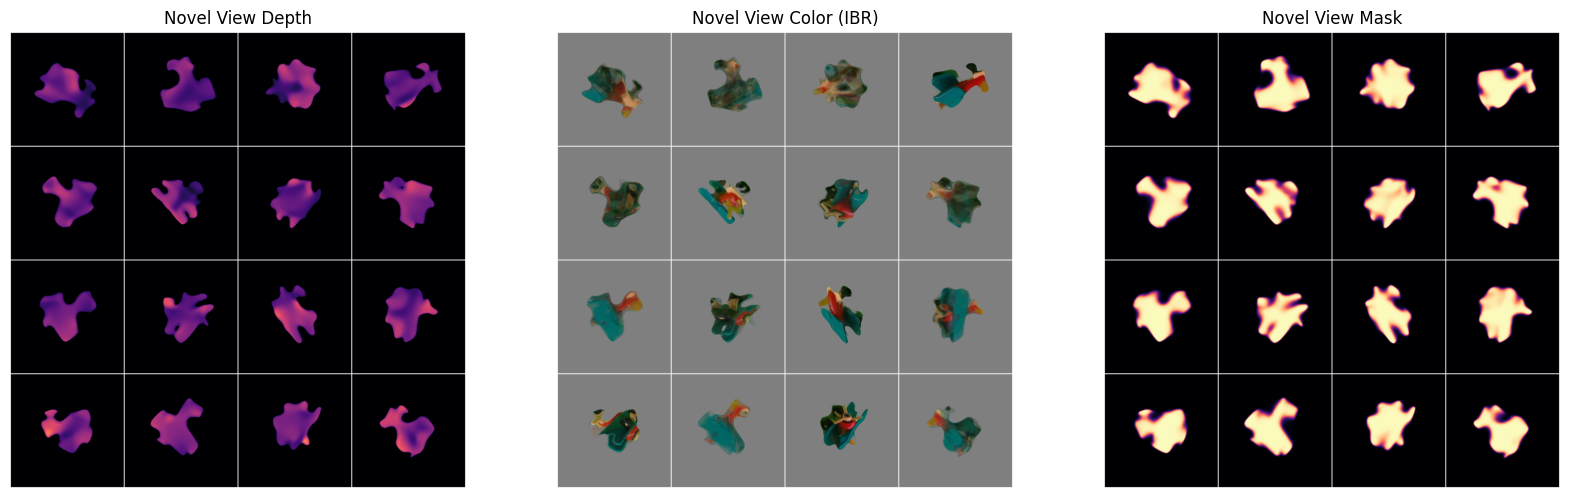

In [1]:
# Imports
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import os
from pathlib import Path
import numpy as np
import torch
from torch.backends import cudnn
import torch.utils.model_zoo

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# use `pwd` to find the path to `latentfusion-az-fork`. 
MOPED_PATH = Path('/home/icore-az/latentfusion-az-fork/datasets/moped')
# LINEMOD_PATH = Path('')
CHECKPOINT = Path('/home/icore-az/latentfusion-az-fork/weights')

num_input_views = 8 # How many reference images to use?

from latentfusion.recon.inference import LatentFusionModel
checkpoint = torch.load('/home/icore-az/latentfusion-az-fork/weights/latentfusion-release.pth')
model = LatentFusionModel.from_checkpoint(checkpoint, device)

from latentfusion.recon.inference import Observation
from latentfusion.pose import bop
from latentfusion.datasets.bop import BOPDataset
from latentfusion.datasets.realsense import RealsenseDataset
import latentfusion.visualization as viz
from latentfusion.augment import gan_denormalize
from latentfusion import meshutils
from latentfusion import augment

from latentfusion import utils
from latentfusion.pose import utils as pose_utils
from latentfusion.modules.geometry import Camera

from latentfusion import three
import math


object_id = 'toy_plane'
frame = 100

input_scene_dir = MOPED_PATH / object_id / 'reference'
target_scene_dir = MOPED_PATH / object_id / 'evaluation'

pointcloud_path = input_scene_dir / 'integrated_registered_processed.obj'
obj = meshutils.Object3D(pointcloud_path)
pointcloud = torch.tensor(obj.vertices, dtype=torch.float32)
diameter = obj.bounding_diameter
object_scale = 1.0 / diameter
object_scale_to_meters = 1.0 / object_scale

input_paths = [x for x in input_scene_dir.iterdir() if x.is_dir()]
input_dataset = RealsenseDataset(input_paths,
                                 image_scale=1.0,
                                 object_scale=object_scale,
                                 odometry_type='open3d')
target_paths = sorted([x for x in target_scene_dir.iterdir() if x.is_dir()])
target_dataset = RealsenseDataset(target_paths,
                                  image_scale=1.0,
                                  object_scale=object_scale,
                                  odometry_type='open3d',
                                  use_registration=True)

input_obs = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))
target_obs = Observation.from_dataset(target_dataset, inds=list(range(len(target_dataset)))[frame:frame+1])

input_obs_pp = model.preprocess_observation(input_obs)
input_obs_pp_gt = model.preprocess_observation(input_obs)
target_obs_pp = model.preprocess_observation(target_obs)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(gan_denormalize(input_obs_pp.color), nrow=4)
plt.subplot(132)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(input_obs_pp.mask), nrow=4)

# Build latent object representation

with torch.no_grad():
    z_obj = model.build_latent_object(input_obs_pp)

    # Visualize prediction.
    camera = input_obs_pp.camera.clone()
    y, z = model.render_latent_object(z_obj, camera.to(device))

recon_error = (y['depth'].detach().cpu() - input_obs_pp_gt.depth).abs()
print('recon_error', recon_error.mean().item())
    
plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4, title='GT Depth')
plt.subplot(132)
viz.show_batch(viz.colorize_depth(y['depth'].detach().cpu()), nrow=4, title='Predicted Depth')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(recon_error), nrow=4, title='Error')

from latentfusion.three.orientation import evenly_distributed_quats
num_novel = 16
camera_ref = input_obs.camera[0]
camera_ref = camera_ref.zoom(None, model.camera_dist, model.input_size)
quats = evenly_distributed_quats(num_novel, upright=True).to(device)
camera_test = camera_ref.clone().repeat(num_novel)
camera_test.quaternion = quats

with torch.no_grad():
    y, _ = model.render_ibr_basic(z_obj, input_obs, camera_test.clone().to(device), apply_mask=True)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(y['depth']), nrow=4, title='Novel View Depth')
plt.subplot(132)
viz.show_batch(gan_denormalize(y['color'].cpu()), nrow=4, title='Novel View Color (IBR)')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(y['mask']), nrow=4, title='Novel View Mask')

import latentfusion.pose.estimation as pe
from functools import partial

estimator = pe.load_from_config('configs/cross_entropy_latent.toml', model, return_camera_history=False, verbose=False)


## Coarse Pose Estimation

In [ ]:
coarse_camera = estimator.estimate(z_obj, target_obs[0])

In [3]:
# camera_zoom = coarse_camera.zoom(None, model.camera_dist, model.input_size)

# # Visualize prediction.
# pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
# pred_mask = pred_y['mask'].squeeze(0)
# pred_depth = pred_y['depth'].squeeze(0)
# pred_depth = camera_zoom.denormalize_depth(pred_depth) * pred_mask
# pred_depth, _ = camera_zoom.uncrop(pred_depth)
# pred_mask, _ = camera_zoom.uncrop(pred_mask)
# pred_depth = pred_depth.cpu()
# pred_mask = pred_mask.cpu()

# plt.figure(1, figsize=(10, 10))
# plt.subplot(131)
# viz.show_batch(target_obs.color[0], nrow=2)
# plt.subplot(132)
# viz.show_batch(viz.colorize_tensor(target_obs[0].depth.cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
# plt.subplot(133)
# viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask.cpu()), nrow=2)

# plt.figure(2, figsize=(20, 10))
# plt.subplot(121)
# viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

# plt.subplot(122)
# viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

### Fine Pose Estimation

In [4]:


# sgd_estimator = pe.load_from_config('configs/adam_quick.toml', model, track_stats=True, return_camera_history=True, num_iters=100)

# init_camera = coarse_camera.clone()
# refined_camera, stat_history, camera_history = sgd_estimator.estimate(z_obj, target_obs[0], camera=init_camera)
# camera_zoom = refined_camera.zoom(None, model.camera_dist, model.input_size)

# # Visualize prediction.
# pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
# pred_mask = pred_y['mask'].squeeze(0)
# pred_depth = pred_y['depth'].squeeze(0)
# pred_depth = camera_zoom.denormalize_depth(pred_depth) * (pred_y['mask'].squeeze(0) > 0.5)
# pred_depth, _ = camera_zoom.uncrop(pred_depth)
# pred_mask, _ = camera_zoom.uncrop(pred_mask)
# depth_error = (target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()
# pred_depth = pred_depth.cpu()
# pred_mask = pred_mask.cpu()
# depth_error = depth_error.cpu()

# plt.figure(1, figsize=(10, 10))
# plt.subplot(131)
# viz.show_batch(target_obs.color[0], nrow=2)
# plt.subplot(132)
# viz.show_batch(viz.colorize_tensor(target_obs[0].depth, cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
# plt.subplot(133)
# viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask), nrow=2)

# plt.figure(2, figsize=(20, 10))
# plt.subplot(121)
# viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

# plt.subplot(122)
# viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

In [5]:
# from latentfusion.pose.metrics import camera_metrics
# from latentfusion.pose.format import metrics_table_multiple


# for j in range(1):
#     print(metrics_table_multiple([
#             camera_metrics(target_obs.camera, coarse_camera[j], pointcloud, object_scale_to_meters),
#             camera_metrics(target_obs.camera, refined_camera[j], pointcloud, object_scale_to_meters),
#     ], ['Coarse', 'Refined'], tablefmt='simple'))

### Plot pose refinement stats over time

In [6]:
# import math

# viz.plot_grid(3, figsize=(30, 15), plots=[
#     viz.Plot('Angular Error', [stat_history['angle_dist']/math.pi*180], 
#              params={'ylabel': 'Error (deg)', 'xlabel': 'Iteration'}),
#     viz.Plot('Translation Error', [stat_history['trans_dist']*object_scale_to_meters], 
#              params={'ylabel': 'Error (m)', 'xlabel': 'Iteration'}),
#     viz.Plot('Rank Loss', [stat_history['rank_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('Optim Loss', [stat_history['optim_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    
#     viz.Plot('Depth Loss', [stat_history['depth_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('Overlap Depth Loss', [stat_history['ov_depth_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('Mask Loss', [stat_history['mask_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('IOU Loss', [stat_history['iou_loss']], 
#              params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
#     viz.Plot('<5 deg <5 cm', [(stat_history['trans_dist']*object_scale_to_meters < 0.05) & (stat_history['angle_dist']/math.pi*180 < 5)], 
#              params={'ylabel': 'Success', 'xlabel': 'Iteration'}),
# ])